In [17]:
import numpy as np
import gzip
import pickle
import networkx as nx
import matplotlib.pyplot as plt
import scipy.stats
import scipy.spatial

In [18]:
%matplotlib inline

In [19]:
def load(networkx_path):
    with gzip.open(networkx_path, 'rb') as f:
        G = pickle.load(f)
    return G

G = load('./graphs/graph_mf_grc_binary_210519.gz')

In [9]:
grc_nodes = [n for n in G.nodes(data=True) if n[1]['cell_type'] == 'grc']
mf_nodes = [n for n in G.nodes(data=True) if n[1]['cell_type'] == 'mf'] 

num_mf = len(np.unique([n[1]['mf_id'] for n in mf_nodes]))
print("Number of GrC: %s" % len(grc_nodes))
print("Number of MFs: %s" % num_mf)
print("Number of MF boutons: %s" % len(mf_nodes))

Number of GrC: 3953
Number of MFs: 729
Number of MF boutons: 1070


In [10]:
# Define an ROI box (in nm). We do this for 2 reasons:
# 1. Specify where GrCs and MFs were densely proofread.
# 2. Exclude counting GrCs near the edges of the EM volume.
# This is because GrCs near the edges are missing GrC partners that we cannot observe.
# Note that we use all neurons for counting, but we only count sharing statistics of the GrCs within the ROI.
# Also note there is no restriction for the Y axis.

# For Z, we count GrCs of the inner 10um out of the available ~50um.
z_min = 19800
z_max = 29800

# In X dimension, GrCs are fully reconstructed and proofread from 90k to 150k
# MFs are from 70k to 160k. Here we conservatively use an even smaller ROI:
x_min = 105*1000*4
x_max = 135*1000*4

In [11]:
# Get grc and mf lists
all_grcs = []
all_boutons = []
for n in G.nodes():
    if G.nodes[n]['cell_type'] == 'grc':
        all_grcs.append(n)
    # If not a GrC its a bouton
    else:
        all_boutons.append(n)
  
central_grcs = []      
for grc in all_grcs:
    x, y, z = G.nodes[grc]['xyz']
    # Outside the bounds of observation
    if x < x_min or x > x_max:
        continue
    if z < z_min or z > z_max:
        continue
    central_grcs.append(grc) 

In [12]:
import copy
from collections import defaultdict

def grc_sharing(in_graph, unique_count=False, return_counted=False):
    replication_hist2 = defaultdict(int)
    grc_ids = set()
    mf_ids = set()
    replicated_2shares = defaultdict(int)
    n_common_pairs = 0
    processed = set()
    total_n_pairs = 0
    hist = defaultdict(int)
    counted_grcs = 0
    # Only analyze the connectivity of some GrCs
    for grc_i_id in central_grcs:
        counted_grcs += 1
        grc_ids.add(grc_i_id)
        # See which boutons correspond to the GrC, same bouton might connect to GrC multiple times so
        # we need to take the set
        rosettes_i = set(list(in_graph.predecessors(grc_i_id)))
        for r in rosettes_i:
            mf_ids.add(r)
        # For the set of some GrCs, check their connectivity to all other GrCs (because two GrCs may not be close together and still be connected to the same bouton)
        for grc_j_id in all_grcs:
            if grc_i_id == grc_j_id:
                continue
            # Won't double-count common boutons for a pair of GrCs
            if unique_count and (grc_i_id, grc_j_id) in processed:
                continue
            processed.add((grc_i_id, grc_j_id))
            processed.add((grc_j_id, grc_i_id))
            rosettes_j = set(list(in_graph.predecessors(grc_j_id)))
            # Combine the sets
            common_rosettes = rosettes_i & rosettes_j
            # Count of number of grc pairs which share n common rosettes
            # Number of pairs is number of GrCs squared
            hist[len(common_rosettes)] += 1
            # >= 2 shared boutons for a GrC
            if len(common_rosettes) >= 2:
                # Number of other GrCs a certain GrC shares at least a pair of boutons with
                replication_hist2[grc_i_id] += 1
                common_rosettes = tuple(sorted(list(common_rosettes)))
                # Number of GrC cells which share a given pair of boutons
                replicated_2shares[common_rosettes] += 1
            
    for k in hist:
        # fix 0 data point for log plots
        if hist[k] == 0:
            hist[k] = 1
    if return_counted:
        return hist, replicated_2shares, replication_hist2, counted_grcs
    else:
        return hist, replicated_2shares, replication_hist2

input_observed = copy.deepcopy(G)
hist_data, shares, rep_hist = grc_sharing(input_observed)

In [13]:
def plot_pair_sharing(pairs_hist):
    replication_hist_list = []
    for grc in central_grcs:
        if grc in pairs_hist:
            replication_hist_list.append((grc, pairs_hist[grc]))
        else:
            replication_hist_list.append((grc, 0))
    # Sorted list of the number of other GrCs each GrC shares at least 2 boutons with
    replication_hist_list_sorted = sorted(replication_hist_list, key=lambda a: a[1])
    x = [e[1] for e in replication_hist_list_sorted]
    y = np.arange(len(x)) / len(x)
    return x, y

In [14]:
# reconstructed_x, reconstructed_y = plot_pair_sharing(rep_hist)
# plt.plot(reconstructed_x, reconstructed_y)
# plt.xticks(np.arange(0, 16, step=5))
# plt.yticks(np.arange(0, 1.1, step=0.2))
# plt.xlabel("No. of GrC pairs sharing ≥ 2 MFs")
# plt.ylabel("Cumulative fraction of GrCs")
# plt.show()

In [15]:
# Radius (threshold) model where you make the radius as either the average of the GrC dendrite length distribution, or by respecting the distribution of GrC dendrite length
# For each GrC, choose the boutons which fall within the radius and either take the mean of the dendrites per GrC distribution, follow the distribution, or for each GrC connect it to the number of boutons for which it has that number of dendrites
# Run Wilcoxon test to find difference between actual distribution and random one
# Go back and create Erdos Renyi model - connection probability is the (number of edges) / (number of MF * number of GrC)
# - Also try model where for each GrC, select a set of MF at random (the number you select is the indegree of the GrC)

In [20]:
# GrC bounds (nm)

# y bounds don't need to be accounted for b/c they are natural boundaries (depth of GrC layer)
dendrite_z_bound = 80*1000
# 20 um from lower reconstruction bound
dendrite_z_min = 0 + 20*1000
# 20 um from higher reconstruction bound
dendrite_z_max = dendrite_z_bound - 20*1000

dendrite_x_bound = 320 * 1000 * 4
# 60 um from lower reconstruction bound
dendrite_x_min = 0 + 60*1000*4
# 60 um from higher reconstruction bound
dendrite_x_max = dendrite_x_bound - 60*1000*4

dendrite_calc_grcs = [n for n in all_grcs if dendrite_x_min < G.nodes[n]['xyz'][0] < dendrite_x_max and dendrite_z_min < G.nodes[n]['xyz'][2] < dendrite_z_max]
degree = [t[1] for t in G.in_degree(dendrite_calc_grcs)]
degree_counts = np.unique(degree, return_counts=True)[1] / len(dendrite_calc_grcs)
x = np.unique(degree, return_counts=True)[0]
fig = plt.figure(figsize =(10, 7))
plt.bar(x, degree_counts)
plt.xlabel("# of dendrites per GrC")
plt.ylabel("Probability")
plt.savefig("./figures/Num dendrites per GrC.png")
plt.close(fig)

dendrite_lengths = []
for v in central_grcs:
    for u in G.predecessors(v):
        dendrite_lengths.append(scipy.spatial.distance.euclidean(G.nodes[u]['xyz'], G.nodes[v]['xyz']))

# Dendrite lengths in nm, useful for radius-distribution random model later
dendrite_lengths = np.array(dendrite_lengths)

dendrite_lengths_um = dendrite_lengths / 1000
# Turn dendrite lengths to um
length_counts, bins = np.histogram(dendrite_lengths_um, bins='auto', density=True)
fig = plt.figure(figsize=(10, 7))
plt.bar(bins[:-1], length_counts)
plt.xlabel("GrC dendrite lengths (um)")
plt.ylabel("Probability")
plt.savefig("./figures/GrC dendrite lengths.png")
plt.close(fig)

In [21]:
# average dendrite radius in nm
# uses radius model with average dendrite length for radius and average GrC in-degree
from scipy.stats import gaussian_kde
# If radius dist is false, it will perform thresholding based on average dendrite length
# Otherwise it will generate a radius based on the distribution of dendrite lengths
# If degree dist is false, it will choose the number of boutons based on average in-degree
# Otherwise it will choose the number of boutons that the GrC cell had in the actual graph
def get_random_model(radius_dist = False, degree_dist = False):
    # Turn distance to nm from um
    radius = np.mean(dendrite_lengths)
    avg_degree = int(np.mean(degree))
    random_model = nx.create_empty_copy(G, with_data=True)
    rng = np.random.default_rng()
    pdf = gaussian_kde(dendrite_lengths)
    probs = pdf.evaluate(dendrite_lengths)
    norm_probs = probs / sum(probs) 
    for grc in all_grcs:
        candidates = []
        if radius_dist:
            radius = rng.choice(dendrite_lengths, replace=True, p=norm_probs)
        # In the future, search for neighboring boutons using NetworkX methods
        # nx.edge_subgraph(nx.geometric_edges(G, radius))
        for bouton in all_boutons:
            if scipy.spatial.distance.euclidean(G.nodes[bouton]['xyz'], G.nodes[grc]['xyz']) <= radius:
                candidates.append(bouton)
        if len(candidates) > 0:
            sample_size = avg_degree
            if degree_dist:
                sample_size = G.in_degree(grc)
            if len(candidates) < sample_size:
                sample_size = len(candidates)
            sample = rng.choice(candidates, size=sample_size, replace=False)
            for s in sample:
                random_model.add_edge(s, grc)
    return random_model

In [22]:
# Boutons sorted by the MF they belong to and their numbering within the bouton
def bouton_sort(x):
    mf_id_str = x[1]['mf_id'].split("_")[1]
    # Accounting for badly labeled boutons
    if mf_id_str == 'like':
        mf_id_str = x[1]['mf_id'].split("_")[2]
    mf_id = int(mf_id_str)
    bouton_id = int(x[0].split("__")[1])
    return mf_id, bouton_id

In [23]:
# GrC sorted by their index
def grc_sort(x):
    # Accounting for the badly labeled grcs
    if x[0].split("_")[1] == 'dendrite':
        return int(x[0].split("_")[2])
    return int(x[0].split("_")[1])

In [24]:
def erdos_renyi():
    num_presyn = len(all_boutons)
    num_postsyn = len(all_grcs)
    edge_prob = len(G.edges) / (num_presyn * num_postsyn)
    erdos_renyi_graph = nx.bipartite.random_graph(num_presyn, num_postsyn, edge_prob, directed=True)
    
    sorted_boutons = sorted(mf_nodes, key=bouton_sort)
    sorted_grcs = sorted(grc_nodes, key=grc_sort)
    
    all_sorted = []
    all_sorted.extend(sorted_boutons)
    all_sorted.extend(sorted_grcs)
    names = [n[0] for n in all_sorted]
    attributes = [n[1] for n in all_sorted]
    old_mapping = list(range(len(erdos_renyi_graph.nodes)))
    new_mapping = names
    random_model = nx.relabel_nodes(erdos_renyi_graph, dict(zip(old_mapping, new_mapping)))
    nx.set_node_attributes(random_model, dict(zip(names, attributes)))
    return random_model

In [25]:
# Configuration fixing both outdegree of bouton and indegree of GrC
def fixed_MF_GrC():
    sorted_boutons = sorted(mf_nodes, key=bouton_sort)
    sorted_grcs = sorted(grc_nodes, key=grc_sort)
    
    all_sorted = []
    all_sorted.extend(sorted_boutons)
    all_sorted.extend(sorted_grcs)
    
    bouton_outdegrees = list(map(lambda x: G.out_degree(x[0]), sorted_boutons))
    grc_indegrees = list(map(lambda x: G.in_degree(x[0]), sorted_grcs))
    
    names = [n[0] for n in all_sorted]
    attributes = [n[1] for n in all_sorted]
    
    random_model = nx.bipartite.configuration_model(bouton_outdegrees, grc_indegrees, create_using=nx.Graph())
    
    old_mapping = list(range(len(random_model.nodes)))
    new_mapping = names
    random_model = nx.relabel_nodes(random_model, dict(zip(old_mapping, new_mapping)))
    nx.set_node_attributes(random_model, dict(zip(names, attributes)))
    
    # Created directed graph from undirected random model
    dir_random_model = nx.create_empty_copy(G, with_data=True)
    dir_random_model.add_edges_from(random_model.edges)
    
    return dir_random_model

In [13]:
# Degree distribution affects model more than radius distribution

In [14]:
_, _, r1_hist = grc_sharing(get_random_model(radius_dist=False, degree_dist=False))
x1, y1 = plot_pair_sharing(r1_hist)

In [15]:
_, _, r2_hist = grc_sharing(get_random_model(radius_dist=True, degree_dist=False))
x2, y2 = plot_pair_sharing(r2_hist)

In [16]:
_, _, r3_hist = grc_sharing(get_random_model(radius_dist=False, degree_dist=True))
x3, y3 = plot_pair_sharing(r3_hist)

In [17]:
_, _, r4_hist = grc_sharing(get_random_model(radius_dist=True, degree_dist=True))
x4, y4 = plot_pair_sharing(r4_hist)

In [18]:
reconstructed_x, reconstructed_y = plot_pair_sharing(rep_hist)
p_vals = []
for x in [x1, x2, x3, x4]:
    res = scipy.stats.wilcoxon(reconstructed_x, x)
    p_vals.append(res.pvalue)
wilcox_p_val = np.mean(p_vals)

In [147]:
scipy.stats.wilcoxon(reconstructed_x, x3).statistic

71.5

In [254]:
erdos_renyi_model = erdos_renyi()
_, _, erdos_grc_hist = grc_sharing(erdos_renyi_model)
erdos_x, erdos_y = plot_pair_sharing(erdos_grc_hist)

In [255]:
fixed_degree_model = fixed_MF_GrC()
_, _, fixed_degrees_hist = grc_sharing(fixed_degree_model)
fixed_x, fixed_y = plot_pair_sharing(fixed_degrees_hist)

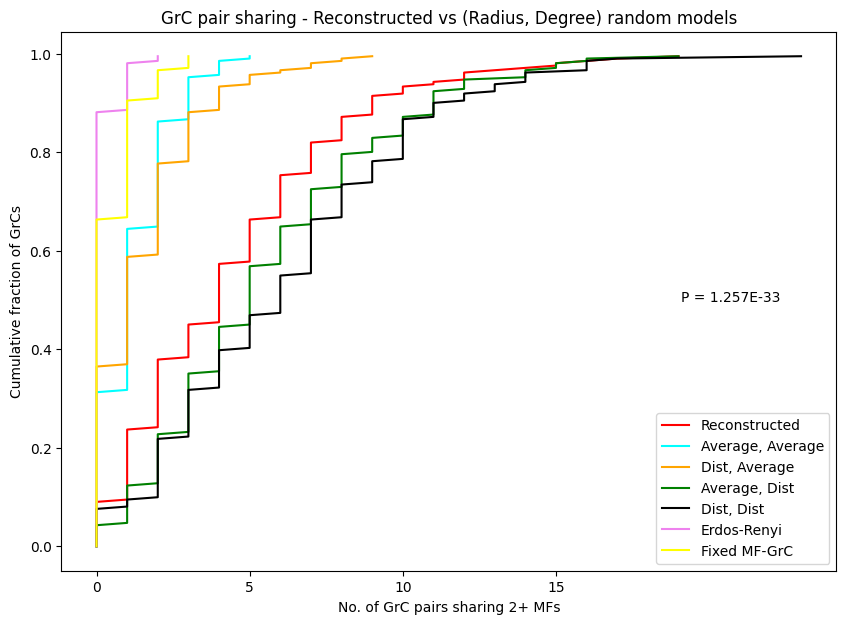

In [256]:
fig = plt.figure(figsize=(10, 7))
plt.plot(reconstructed_x, reconstructed_y, color='red', label='Reconstructed')
plt.plot(x1, y1, color='cyan', label='Average, Average')
plt.plot(x2, y2, color='orange', label='Dist, Average')
plt.plot(x3, y3, color='green', label='Average, Dist')
plt.plot(x4, y4, color='black', label='Dist, Dist')
plt.plot(erdos_x, erdos_y, color='violet', label='Erdos-Renyi')
plt.plot(fixed_x, fixed_y, color='yellow', label='Fixed MF-GrC')
plt.xticks(np.arange(0, 16, step=5))
plt.yticks(np.arange(0, 1.1, step=0.2))
plt.xlabel("No. of GrC pairs sharing 2+ MFs")
plt.ylabel("Cumulative fraction of GrCs")
plt.title("GrC pair sharing - Reconstructed vs (Radius, Degree) random models")
plt.text(0.8, 0.5, "P = {:0.3E}".format(wilcox_p_val), transform = fig.get_axes()[0].transAxes)
plt.legend()
plt.savefig("./figures/GrC Pair Sharing.png")
plt.show()
plt.close(fig)

In [20]:
# Same ROI box for boutons
bouton_z_min = 19800
bouton_z_max = 29800

bouton_x_min = 105*1000*4
bouton_x_max = 135*1000*4

central_boutons = []      
for bouton in all_boutons:
    x, y, z = G.nodes[bouton]['xyz']
    # Outside the bounds of observation
    if x < bouton_x_min or x > bouton_x_max:
        continue
    if z < bouton_z_min or z > bouton_z_max:
        continue
    central_boutons.append(bouton) 

In [21]:
def bouton_postsyns(in_graph):
    hist = defaultdict(int)
    for bouton_i_id in central_boutons:
        num_grcs = len(list(in_graph.successors(bouton_i_id)))
        hist[bouton_i_id] = num_grcs
    return hist

def plot_num_postsyns(hist):
    postsyn_hist_list = []
    for bouton in central_boutons:
        if bouton in hist:
            postsyn_hist_list.append((bouton, hist[bouton]))
        else:
            postsyn_hist_list.append((bouton, 0))
    # Sorted list of number of postsynaptic boutons
    postsyn_hist_sorted = sorted(postsyn_hist_list, key=lambda a: a[1])
    x = [e[1] for e in postsyn_hist_sorted]
    y = np.arange(len(x)) / len(x)
    return x, y

input_observed = copy.deepcopy(G)
hist_data = bouton_postsyns(input_observed)
postsyn_reconstructed_x, postsyn_reconstructed_y = plot_num_postsyns(hist_data)

In [22]:
p1_hist = bouton_postsyns(get_random_model(radius_dist=False, degree_dist=False))
postsyn_x1, postsyn_y1 = plot_num_postsyns(p1_hist)
p2_hist = bouton_postsyns(get_random_model(radius_dist=True, degree_dist=False))
postsyn_x2, postsyn_y2 = plot_num_postsyns(p2_hist)
p3_hist = bouton_postsyns(get_random_model(radius_dist=False, degree_dist=True))
postsyn_x3, postsyn_y3 = plot_num_postsyns(p3_hist)
p4_hist = bouton_postsyns(get_random_model(radius_dist=True, degree_dist=True))
postsyn_x4, postsyn_y4 = plot_num_postsyns(p4_hist)

In [23]:
kurtosis_reconstructed = scipy.stats.kurtosis(postsyn_reconstructed_x)
kurtosis_random = scipy.stats.kurtosis(postsyn_x4)
# Permutation test of difference of means
def statistic(x, y):
    return np.mean(x) - np.mean(y)
res = scipy.stats.permutation_test((postsyn_reconstructed_x, postsyn_x1), statistic)
dist_p_val = res.pvalue

In [140]:
erdos_postsyn_hist = bouton_postsyns(erdos_renyi_model)
erdos_postsyn_x, erdos_postsyn_y = plot_num_postsyns(erdos_postsyn_hist)

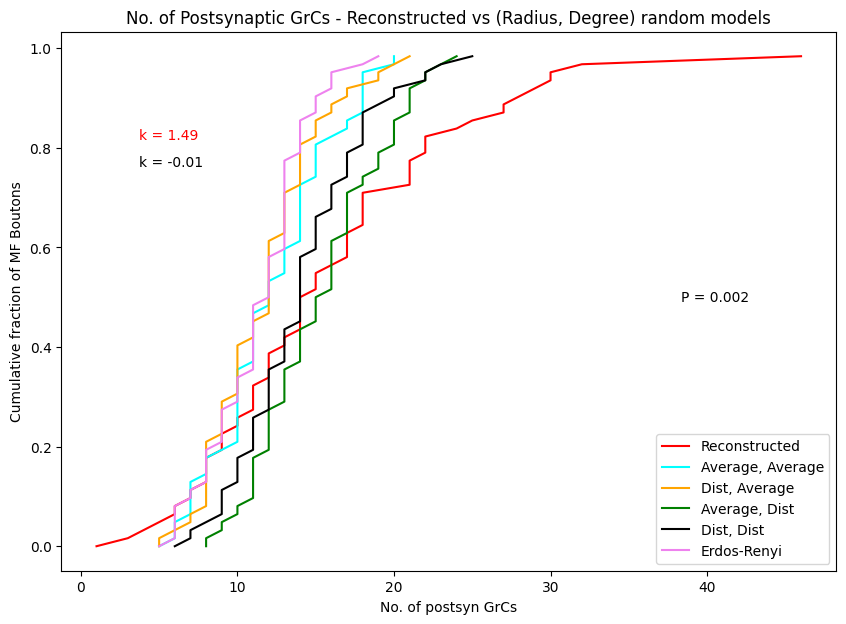

In [141]:
fig = plt.figure(figsize=(10, 7))
plt.plot(postsyn_reconstructed_x, postsyn_reconstructed_y, color='red', label='Reconstructed')
plt.plot(postsyn_x1, postsyn_y1, color='cyan', label='Average, Average')
plt.plot(postsyn_x2, postsyn_y2, color='orange', label='Dist, Average')
plt.plot(postsyn_x3, postsyn_y3, color='green', label='Average, Dist')
plt.plot(postsyn_x4, postsyn_y4, color='black', label='Dist, Dist')
plt.plot(erdos_postsyn_x, erdos_postsyn_y, color='violet', label='Erdos-Renyi')
plt.xticks(np.arange(0, 41, step=10))
plt.yticks(np.arange(0, 1.1, step=0.2))
plt.xlabel("No. of postsyn GrCs")
plt.ylabel("Cumulative fraction of MF Boutons")
plt.title("No. of Postsynaptic GrCs - Reconstructed vs (Radius, Degree) random models")
plt.legend(loc='lower right')

plt.text(0.1, 0.8, "k = {:0.2f}".format(kurtosis_reconstructed), color='red', transform = fig.get_axes()[0].transAxes)
plt.text(0.1, 0.75, "k = {:0.2f}".format(kurtosis_random), color='black', transform = fig.get_axes()[0].transAxes)
plt.text(0.8, 0.5, "P = {:0.3f}".format(dist_p_val), transform = fig.get_axes()[0].transAxes)
plt.savefig("./figures/Postsyn GrCs.png")
plt.show()
plt.close(fig)

In [46]:
def radius_random_model(radius_factor):
    # Turn distance to nm from um
    mu = np.mean(dendrite_lengths) 
    radius = radius_factor * mu
    random_model = nx.create_empty_copy(G, with_data=True)
    rng = np.random.default_rng()
    pdf = gaussian_kde(dendrite_lengths)
    probs = pdf.evaluate(dendrite_lengths)
    norm_probs = probs / sum(probs) 
    for grc in all_grcs:
        candidates = []
        for bouton in all_boutons:
            if scipy.spatial.distance.euclidean(G.nodes[bouton]['xyz'], G.nodes[grc]['xyz']) <= radius:
                candidates.append(bouton)
        if len(candidates) > 0:
            sample_size = G.in_degree(grc)
            if len(candidates) < sample_size:
                sample_size = len(candidates)
            sample = rng.choice(candidates, size=sample_size, replace=False)
            for s in sample:
                random_model.add_edge(s, grc)
    return random_model

In [220]:
left_rad_model = radius_random_model(0.9)
_, _, left_rad_hist = grc_sharing(left_rad_model)
left_rad_x, left_rad_y = plot_pair_sharing(left_rad_hist)

In [221]:
right_rad_model = radius_random_model(1.1)
_, _, right_rad_hist = grc_sharing(right_rad_model)
right_rad_x, right_rad_y = plot_pair_sharing(right_rad_hist)

In [222]:
avg_rad_model = radius_random_model(1)
_, _, avg_rad_hist = grc_sharing(avg_rad_model)
avg_rad_x, avg_rad_y = plot_pair_sharing(avg_rad_hist)

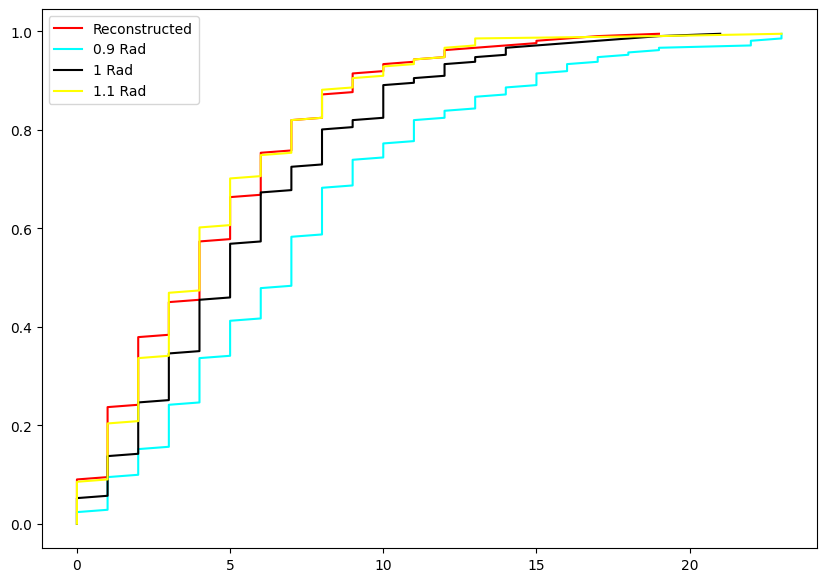

In [223]:
fig = plt.figure(figsize=(10, 7))
plt.plot(reconstructed_x, reconstructed_y, color='red', label='Reconstructed')
plt.plot(left_rad_x, left_rad_y, color='cyan', label='0.9 Rad')
plt.plot(avg_rad_x, avg_rad_y, color='black', label='1 Rad')
plt.plot(right_rad_x, right_rad_y, color='yellow', label='1.1 Rad')
plt.legend()
plt.show()
plt.close(fig)

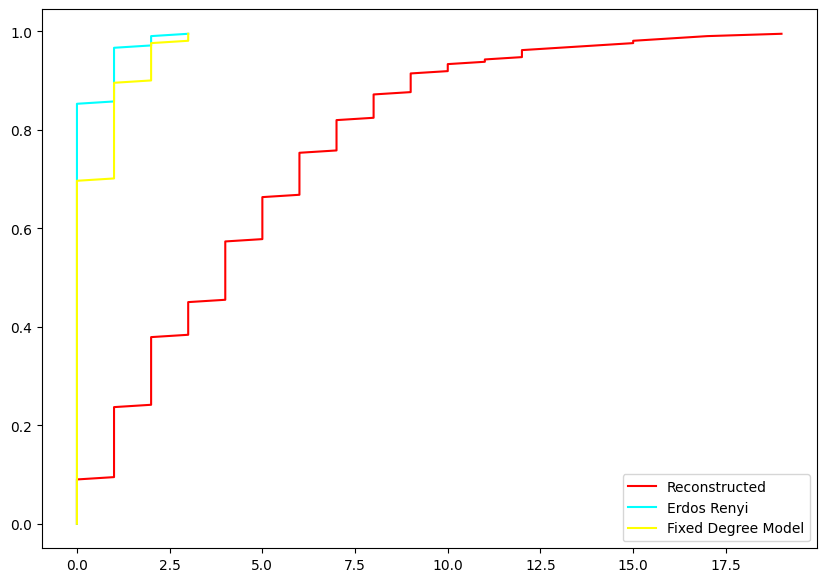

In [204]:
erdos_renyi_model = erdos_renyi()
_, _, erdos_grc_hist = grc_sharing(erdos_renyi_model)
erdos_x, erdos_y = plot_pair_sharing(erdos_grc_hist)
fixed_degree_model = fixed_MF_GrC()
_, _, fixed_degrees_hist = grc_sharing(fixed_degree_model)
fixed_x, fixed_y = plot_pair_sharing(fixed_degrees_hist)
fig = plt.figure(figsize=(10, 7))
plt.plot(reconstructed_x, reconstructed_y, color='red', label='Reconstructed')
plt.plot(erdos_x, erdos_y, color='cyan', label='Erdos Renyi')
plt.plot(fixed_x, fixed_y, color='yellow', label='Fixed Degree Model')
plt.legend()
plt.show()
plt.close(fig)

In [129]:
# erdos_postsyn_hist = bouton_postsyns(erdos_renyi_model)
# erdos_postsyn_x, erdos_postsyn_y = plot_num_postsyns(erdos_postsyn_hist)
# fig = plt.figure(figsize=(10, 7))
# plt.plot(postsyn_reconstructed_x, postsyn_reconstructed_y, color='red', label='Reconstructed')
# plt.plot(postsyn_x1, postsyn_y1, color='cyan', label='Erdos Renyi')
# plt.legend()
# plt.show()
# plt.close(fig)

In [ ]:
# See how robust the random models are - how much would they change if we change the radius parameter
# Need to quantify the amount of uncertainty - take the standard error of the dendrite length distribution
# If we modify how we compute indegree distribution, would that change the random model significantly
# Also look at model which fixes both bouton outdegree and GrC indegree (selects a random pair of possible nodes each time and draws edge between them)

In [214]:
se = scipy.stats.sem(dendrite_lengths)

In [216]:
mu = np.mean(dendrite_lengths)
std = np.std(dendrite_lengths)
cv = (std / mu) * 100
print(cv)

39.04969201004886


In [217]:
(se / mu) * 100

1.3016564003349618

In [28]:
def count_combinations():
    # Turn distance to nm from um
    radius = np.mean(dendrite_lengths)
    permutations_per_grc = []
    for grc in all_grcs:
        num_candidates = 0
        for bouton in all_boutons:
            if scipy.spatial.distance.euclidean(G.nodes[bouton]['xyz'], G.nodes[grc]['xyz']) <= radius:
                num_candidates += 1
        sample_size = G.in_degree(grc)
        p = scipy.special.comb(num_candidates, sample_size)
        permutations_per_grc.append(p)
    return permutations_per_grc

In [29]:
perms = count_combinations()

In [30]:
np.mean(perms)

14420.288641538073

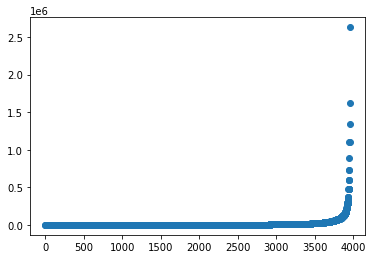

In [32]:
x = np.arange(len(perms))
y = np.sort(perms)
plt.scatter(x, y)

In [43]:
# Exclude outliers
np.mean(y[:-10])

11575.572914024855

Plotted Graph 1
Plotted Graph 2
Plotted Graph 3
Plotted Graph 4
Plotted Graph 5
Plotted Graph 6
Plotted Graph 7
Plotted Graph 8
Plotted Graph 9
Plotted Graph 10


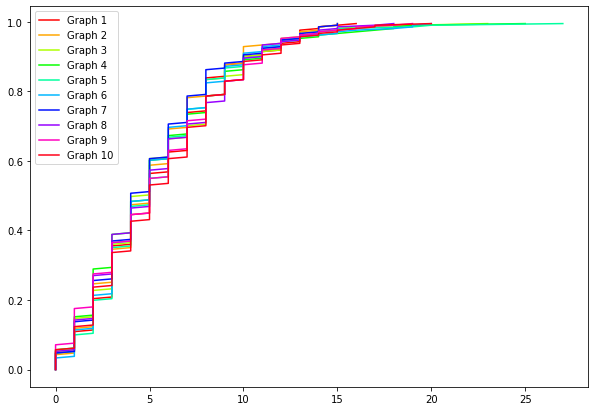

In [48]:
n = 10
cmap = plt.cm.get_cmap('hsv', n)
fig = plt.figure(figsize=(10, 7))
for i in range(n):
    avg_rad_model = radius_random_model(1)
    _, _, avg_rad_hist = grc_sharing(avg_rad_model)
    avg_rad_x, avg_rad_y = plot_pair_sharing(avg_rad_hist)
    plt.plot(avg_rad_x, avg_rad_y, color=cmap(i), label=f'Graph {i+1}')
    print(f"Plotted Graph {i+1}")
plt.legend()
plt.show()
plt.close(fig)

In [ ]:
# Conclusion: some spatial organization is important, but there is also random variability in the connections
# Some wiggle room in the random model capturing the data b/c the reconstructed model falls within the random models
# TODO: create journal on this project